# Sharp Ratio & Frontier

In [39]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

%matplotlib inline

ds_yahoo = 'yahoo'

last_year = datetime.datetime.now().year - 1
start = datetime.datetime.now().replace(year=last_year)
end = datetime.datetime.now()

## Portfolio Atual

### Pegando os dados na API do Yahoo

In [2]:
tickers = ['DVY', 'HDV']

dvy = web.DataReader(tickers[0], ds_yahoo, start, end)
hdv = web.DataReader(tickers[1], ds_yahoo, start, end)

## Normalizando o retorno diário de cada ativo do portfólio

In [3]:
for acao_df in (dvy, hdv):
    acao_df['Retorno Normalizado'] = acao_df['Adj Close'] / acao_df.iloc[0]['Adj Close']

## Alocando cada ativo com um peso específico

In [4]:
pesos = [.5, .5]

for acao_df, alocacao in zip((dvy, hdv), pesos):
    acao_df['Alocacao'] = acao_df['Retorno Normalizado'] * alocacao

## Posição de cada ativo no portfólio

In [5]:
for acao_df in (dvy, hdv):
    acao_df['Posicao'] = acao_df['Alocacao'] * 10000

In [6]:
todas_posicoes = [dvy['Posicao'], hdv['Posicao']]

# DF que terá colunas adicionadas como Total e Retorno Diário
portfolio_posicao = pd.concat(todas_posicoes, axis=1)

# DF que terá apenas as ações com o Adj Close column
portfolio_acoes = pd.concat(todas_posicoes, axis=1)

In [7]:
portfolio_posicao.columns = ['DVY', 'HDV']
portfolio_acoes.columns = portfolio_posicao.columns

## Desempenho da carteira

In [8]:
portfolio_posicao['Total'] = portfolio_posicao.sum(axis=1)

In [9]:
print('Investimento inicial:')
print(portfolio_posicao['Total'][0])
print('Investimento final:')
print(round(portfolio_posicao['Total'][-1], 2))

Investimento inicial:
10000.0
Investimento final:
10541.83


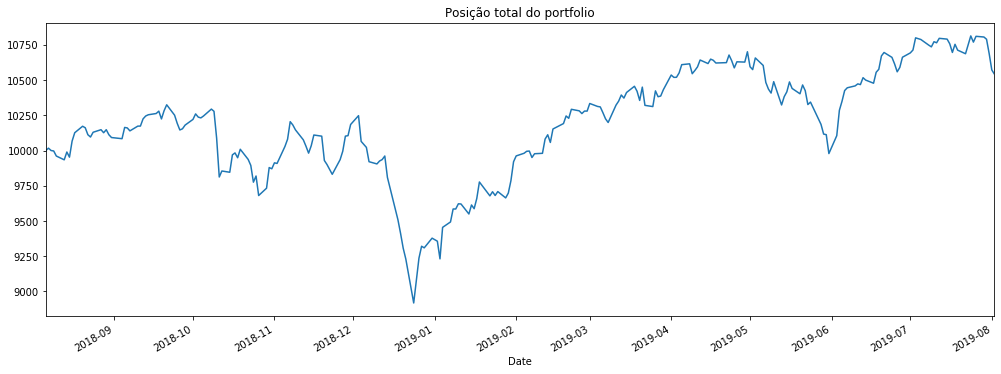

In [10]:
portfolio_posicao['Total'].plot(figsize=(17,6))
plt.title('Posição total do portfolio');

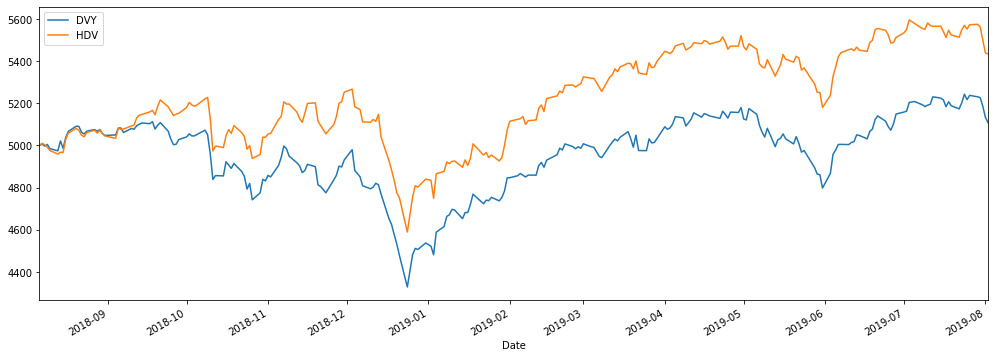

In [11]:
portfolio_acoes.plot(figsize=(17,6));

## Desempenho da Carteira Normalizada

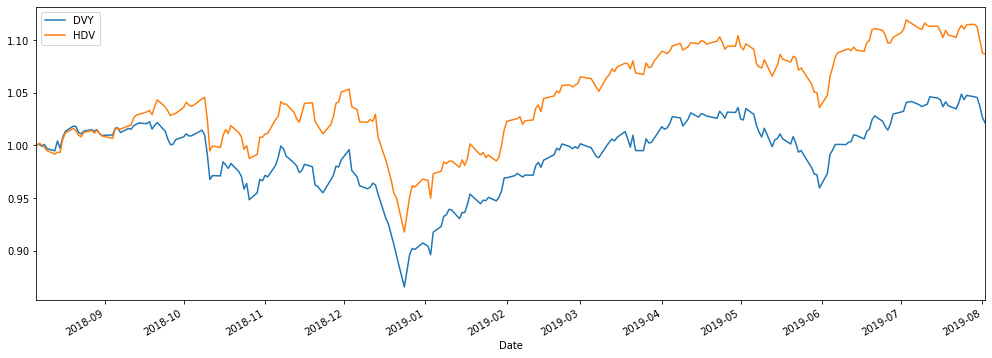

In [12]:
portfolio_normalizado = portfolio_acoes / portfolio_acoes.iloc[0]
portfolio_normalizado.plot(figsize=(17,6));

## Retorno diário da carteira

In [13]:
portfolio_posicao['Retorno Diario'] = portfolio_posicao['Total'].pct_change(1)

In [14]:
# Média de retorno diário
round_ret_medio_diario = round(portfolio_posicao['Retorno Diario'].mean() * 100, 2)
print('Essa carteira rende em média {}% diariamente'.format(round_ret_medio_diario))

Essa carteira rende em média 0.02% diariamente


In [15]:
# Desvio Padrão do retorno diário
portfolio_posicao['Retorno Diario'].std()

0.007494478999926496

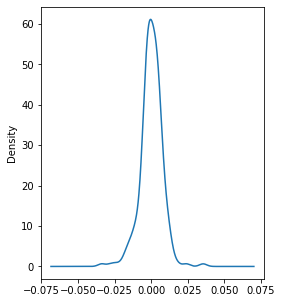

In [16]:
# Gráfico de densidade
portfolio_posicao['Retorno Diario'].plot(kind='kde', figsize=(4,5));

## Retorno Total da Carteira

In [17]:
retorno_total_acumulado = 100 * (portfolio_posicao['Total'][-1] / portfolio_posicao['Total'][0] - 1)
round_ret = round(retorno_total_acumulado, 3)
print('Essa carteira rendeu {} %'.format(round_ret))

Essa carteira rendeu 5.418 %


In [18]:
sharpe_ratio = (portfolio_posicao['Retorno Diario'].mean()) / portfolio_posicao['Retorno Diario'].std()
sharpe_ratio

0.03201632299844967

In [20]:
sharpe_ratio_ano = (len(tickers[0]) ** 0.5) * sharpe_ratio
sharpe_ratio_ano

0.05545389810485077

## Retorno diário

In [21]:
retorno_diario = portfolio_acoes.pct_change(1)

## Gerando um único portfólio com posição atual

In [22]:
print(portfolio_acoes.columns)

# Gerando pesos aleatórios
print("Pesos Atuais")
print(pesos)
print("")

# Rebalanceando os pesos
print("Rebalancear os pesos")
pesos = pesos / np.sum(pesos)
print(pesos)
print("")

# Retorno esperado
print("Retorno esperado")
ret_esp = np.sum( (retorno_diario.mean() * pesos) * len(tickers[0]) )
print(ret_esp)
print("")

# Volatilidade esperada
print("Volatilidade esperada")
vol_esp = np.sqrt( np.dot( pesos.T, np.dot( retorno_diario.cov() * len(tickers[0]), pesos ) ) )
print(vol_esp)
print("")

# Taxa de Sharpe
print("Sharpe Ratio")
sharpe = (ret_esp - 0.065) / vol_esp
print(sharpe)


Index(['DVY', 'HDV'], dtype='object')
Pesos Atuais
[0.5, 0.5]

Rebalancear os pesos
[0.5 0.5]

Retorno esperado
0.0007174649886489006

Volatilidade esperada
0.012977613427673985

Sharpe Ratio
-4.953340255479674


## Gerando milhares de portfólios

In [38]:
num_portfolios = 1000
pesos_arr = np.zeros((num_portfolios, len(portfolio_acoes.columns)))
ret_esp_arr = np.zeros(num_portfolios)
vol_esp_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

for ind in range(num_portfolios):

    # Pesos aleatórios
    pesos = np.array(np.random.random(len(tickers)))
    pesos = pesos / np.sum(pesos)
    pesos_arr[ind,:] = pesos

    # Retorno esperado
    ret_esp_arr[ind] = np.sum( (retorno_diario.mean() * pesos) * len(tickers[0]) )

    # Volatilidade esperada
    vol_esp_arr[ind] = np.sqrt( np.dot( pesos.T, np.dot( retorno_diario.cov() * len(tickers[0]), pesos ) ) )

    # Taxa de Sharpe
    sharpe_arr[ind] = (ret_esp_arr[ind] - 0.065) / vol_esp_arr[ind]

print(portfolio_acoes.columns)
print("")
print(pesos_arr[sharpe_arr.argmax(),:])

Index(['DVY', 'HDV'], dtype='object')

[0.00173674 0.99826326]


In [28]:
sharpe_arr.max()

-4.775282310455305

In [26]:
pesos_arr[sharpe_arr.argmax(),:]

array([0.0010679, 0.9989321])